In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid', 'seaborn-colorblind'])
from pymc3.step_methods import smc
from tempfile import mkdtemp
from scipy.special import betaln
from scipy.stats import beta

# Bayes Factors and Marginal Likelihood


The "Bayesian way" to compare models is to compute the _marginal likelihood_ of each model $p(y \mid M_k)$, _i.e._ the probability of the observed data $y$ given the $M_k$ model. This quantity, the marginal likelihood, is just the normalizing constant of the Bayes' theorem. We can see this if we write Bayes' theorem and make explicit the fact that all inferences are model-dependant. 

$$p (\theta \mid y, M_k ) = \frac{p(\theta \mid \theta, M_k) p(\theta \mid M_k)}{p( y \mid M_k)}$$

where:
* $y$ is the data
* $\theta$ the parameters
* $M_k$ one model out of K competing models


Usually when doing inference we do not need to compute this normalizing constant, so in practice we often compute the posterior up to a constant factor, that is:

$$p (\theta \mid y, M_k ) \propto p(\theta \mid \theta, M_k) p(\theta \mid M_k)$$

However, for model comparison and model averaging the marginal likelihood is an important quantity. Although, it's not the only way to perform these tasks, you can read about model averaging and model selection using alternative methods [here](model_comparison.ipynb), [there](model_averaging.ipynb) and [elsewhere](GLM-model-selection.ipynb).

## Bayesian model selection

If our main objective is to choose only one model, the _best_ one, from a set of models we can just choose the one with the largest $p(y \div M_k)$. This is totally fine if all models are assumed to have the same _a priori_ probability. Otherwise, we have to take into account that not all models are equally likely _a priori_ and compute:

$$p(M_k \mid y) \propto p(y \mid M_k) p(M_k)$$

Sometimes the main objective is not to just keep a single model but instead to compare models to determine which ones are more likely and by how much. This can be achieved using Bayes factors:

$$BF =  \frac{p(y \mid M_0)}{p(y \mid M_1)}$$

that is, the ratio between the marginal likelihood of two models. The larger the BF the _better_ the model in the numerator (M_0 in this example). To ease the interpretation of the BF some authors have proposed tables with levels of _support_ or _strength_, a way to put numbers into words. 

* 1-3: anecdotal
* 3-10: moderate
* 10-30: strong
* 30-100: very strong
* $>$ 100: extreme

Notice that if you get numbers below 0 then the support is for the model in the denominator, tables for those cases are also available. Of course, you can also just take the inverse of the values in the above table or take the inverse of the BF value and you will be OK.

Is very important to remember that these rules are just conventions, simple guides at best. Results should always be put into context of our problems and should be accompanied with enough details that others could potentially check if they agree with our conclusions. The evidence necessary to make a claim is not the same in particle physics, or a court, or to evacuate a town to prevent hundreds of deaths. 

## Bayesian model averaging

Instead of choosing one single model from a set of candidate models, model averaging is about getting one meta-model by averaging the separate models. The Bayesian version of this weights each model by its marginal posterior probability.

$$p(\theta \mid y) = \sum_{k=1}^K p(\theta \mid y, M_k) p(M_k \mid y)$$

This is the optimal way to average models if the prior is _correct_ and the _correct_ model is one of the $M_k$ models in our set. Otherwise, _bayesian model averaging_ will asymptotically select the one single model in the set of compared models that is closest in [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

Check this [example](model_averaging.ipynb) as an alternative way to perform model averaging.

##  Some remarks

Now we will briefly discuss some key facts about the _marginal likelihood_

* The good
    * **Occam Razor included**: Models with more parameters have a larger penalization than models with fewer parameters. The intuitive reason is that the larger the number of parameters the more _spread_ the _prior_ with respect to the likelihood.


* The bad
    * Computing the marginal likelihood is, generally, a hard task because it’s an integral of a highly variable function over a high dimensional parameter space. In general this integral needs to be solved numerically using more or less sophisticated methods.
    
$$p(y \mid M_k) = \int_{\theta_k} p(y \mid \theta_k, M_k) p(\theta_k, M_k) d\theta_k$$

* The ugly
    * The marginal likelihood depends **sensitively** on the specified prior $p(\theta_k \mid M_k)$ for each model.

Notice that _the good_ and _the ugly_ are related. Using the marginal likelihood to compare models is a good idea because a penalization for complex models is already included (thus preventing us from overfitting) and, at the same time, a change in the prior will affect the computations of the _marginal likelihood_. At first this sounds a little bit silly we already know that priors affect computations (otherwise we could simply avoid them), but the point here is the word **sensitively**. We are talking about changes in the prior that will keep inference of $\theta$ more or less the same, but could have a big impact in the value of the marginal likelihood.

## Computing Bayes factors

The _marginal likelihood_ is generally not available in closed-form except for some restricted models. For this reason many methods have been devised to compute the _marginal likelihood_ and the derived Bayes factors, some of these methods are so simple and [naive](https://radfordneal.wordpress.com/2008/08/17/the-harmonic-mean-of-the-likelihood-worst-monte-carlo-method-ever/) that works very bad in practice. Most of the useful methods have been originally proposed in the field of Statistical Mechanics. This connection is explained because the marginal likelihood is analogous to a central quantity in statistical physics known as the _partition function_ which in turn is closely related to another very important quantity the _free-energy_. Many of the connections between Statistical Mechanics and Bayesian inference are summarized [here](https://arxiv.org/abs/1706.01428).

### Using a hierarchical model

Computation of Bayes factors can be framed as a hierarchical model, where the high-level parameter is an index assigned to each model and sampled from a categorical distribution. In other words, we perform inference for two (or more) competing models at the same time and we use a discrete _dummy_ variable that _jumps_ between models. How much time we spend sampling each model is proportional to $p(M_k \mid y)$.

Some common problems when computing Bayes factors this way is that if one model is better than the other, by definition, we will spend more time sampling from it than from the other model. And this could lead to inaccuracies because we will be undersampling the less likely model. Another problem is that the values of the parameters get updated even when the parameters are not used to fit that model. That is, when model 0 is chosen, parameters in model 1 are updated but since they are not used to explain the data, they only get restricted by the prior. If the prior is too vague, it is possible that when we choose model 1, the parameter values are too far away from the previous accepted values and hence the step is rejected. Therefore we end up having a problem with sampling.

In case we find these problems, we can try to improve sampling by implementing two modifications to our model:

* Ideally, we can get a better sampling of both models if they are visited equally, so we can adjust the prior for each model in such a way to favour the less favourable model and disfavour the most favourable one. This will not affect the computation of the Bayes factor because we have to include the priors in the computation.

* Use pseudo priors, as suggested by Kruschke and others. The idea is simple: if the problem is that the parameters drift away unrestricted, when the model they belong to is not selected, then one solution is to try to restrict them artificially, but only when not used! You can find an example of using pseudo priors in a model used by Kruschke in his book and [ported](https://github.com/aloctavodia/Doing_bayesian_ data_analysis.) to Python/PyMC3.

If you want to learn more about this approach to the computation of the marginal likelihood see [Chapter 12 of Doing Bayesian Data Analysis](http://www.sciencedirect.com/science/book/9780124058880). This chapter also discuss how to use Bayes Factors as a Bayesian alternative to classical hypothesis testing.

### Analytically

For some models, like the beta-binomial model (AKA the _coin-flipping_ model) we can compute the marginal likelihood analytically. If we write this model as:

$$\theta \sim Beta(\alpha, \beta)$$
$$y \sim Bin(n=1, p=\theta)$$

the _marginal likelihood_ will be:

$$p(y) = \binom {n}{h}  \frac{B(\alpha + h,\ \beta + n - h)} {B(\alpha, \beta)}$$

where:

* $B$ is the [beta function](https://en.wikipedia.org/wiki/Beta_function) not to get confused with the $Beta$ distribution
* $n$ is the number of trials
* $h$ is the number of success

Since we only care about the relative value of the _marginal likelihood_ under two different models (for the same data), we can omit the binomial coefficient $\binom {n}{h}$, thus we can write:

$$p(y) \propto \frac{B(\alpha + h,\ \beta + n - h)} {B(\alpha, \beta)}$$

This have been coded in the following cell, with a twist we will be using the `betaln` function instead of the `beta` function, this is done to prevent underflow.

In [2]:
def beta_binom(prior, y):
    """
    Compute the marginal likelihood, analytically, for a beta-binomial model.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    alpha, beta = prior
    h = np.sum(y)
    n = len(y)
    p_y = np.exp(betaln(alpha + h, beta+n-h) - betaln(alpha, beta))
    return p_y

Our data for this example consist on 100 "flips of a coin" and the same number of observed "heads" and "tails". We will compare two models one with a uniform prior and one with a _more concentrated_ prior around $\theta = 0.5$

In [3]:
y = np.repeat([1, 0], [50, 50])  # 50 "heads" and 50 "tails"
priors = ((1, 1), (30, 30))

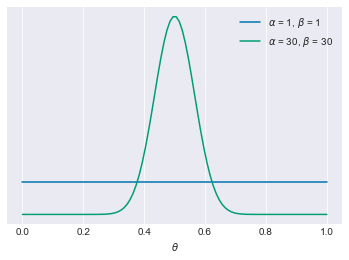

In [4]:
for a, b in priors:
    distri = beta(a, b)
    x = np.linspace(0, 1, 100)
    x_pdf = distri.pdf(x)
    plt.plot (x, x_pdf, label=r'$\alpha$ = {:d}, $\beta$ = {:d}'.format(a, b))
    plt.yticks([])
    plt.xlabel('$\\theta$')
    plt.legend()

The following cell returns the Bayes factor

In [5]:
BF = (beta_binom(priors[1], y) / beta_binom(priors[0], y))
print(round(BF))

5.0


We see that the model with the more concentrated prior $Beta(30, 30)$ has $\approx 5$ times more support than the model with the more extended prior $Beta(1, 1)$. Besides the exact numerical value this should not be surprising since the prior for the most favoured model is concentrated around $\theta = 0.5$ and the data $y$ has equal number of head and tails, consintent with a value of $\theta$ around 0.5.

### Sequential Monte Carlo

The [Sequential Monte Carlo](SMC2_gaussians.ipynb) sampler is a method that basically progress by a series of successive interpolated (or _annealed_) sequences from the prior to the posterior. A nice _by product_ of this process is that we get an estimation of the marginal likelihood.

In [6]:
n_steps = 20
n_chains = 1000

models = []
traces = []
for alpha, beta in priors:
    test_folder = mkdtemp(prefix='SMC_TEST')
    with pm.Model() as model:
        a = pm.Beta('a', alpha, beta, transform=None)
        yl = pm.Bernoulli('yl', a, observed=y)
        trace = smc.sample_smc(n_steps=n_steps,
                               n_chains=n_chains,
                               progressbar=False,
                               homepath=test_folder,
                               stage=0,
                               random_seed=42)
        models.append(model)
        traces.append(trace)

/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/smc.py:480: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/smc.py:120: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.098582 Stage: 1
Initialising chain traces ...
Sampling ...
Beta: 0.801855 Stage: 2
Initialising chain traces ...
Sampling ...
Beta > 1.: 1.999999
Sample final stage
Initialising chain traces ...
Sampling ...
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/smc.py:480: UserWarning: Warning: SMC is an exper

In [7]:
BF_smc = models[1].marginal_likelihood / models[0].marginal_likelihood
print(round(BF_smc))

5.0


As we can see from the previous cell, SMC give essentially the same answer than the analytical calculation! 

The advantage of using SMC is that we can use it to compute the _marginal likelihood_ for a wider range of models, given that we do not need an analytical expression for the _marginal likelihood_. The cost we pay is that the computations is more expensive with SMC, we should take into account that for more complex models we should need to increase the number of `n_steps` and `n_chains` for a more accurate estimation of the _marginal likelihood_.

## Bayes factors and inference

In this example we have used Bayes factors to judge which model seems to be better at explaining the data, and we get that one of the models is $\approx 5$ _better_ than the other. 

But what about the posterior we get from these models? How different they are?

In [8]:
pm.df_summary(traces[0], varnames='a').round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.5,0.05,0.0,0.4,0.59


In [9]:
pm.df_summary(traces[1], varnames='a').round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.5,0.04,0.0,0.43,0.57


We may argue that the results are pretty similar, we have the same mean value for $\theta$, and a slightly wider posterior for `model_0`, as expected since this model has a wider prior. We can also check the posterior predictive distribution to see how similar they are.

100%|██████████| 1000/1000 [00:02<00:00, 394.37it/s]


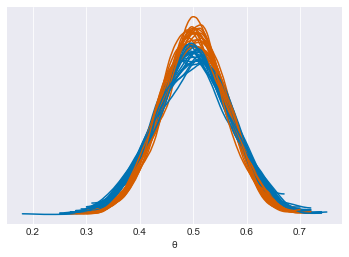

In [10]:
_, ax = plt.subplots()
ppc_0 = pm.sample_ppc(traces[0], 1000, models[0], size=(len(y), 20))
ppc_1 = pm.sample_ppc(traces[1], 1000, models[1], size=(len(y), 20))
for m_0, m_1 in zip(ppc_0['yl'].T, ppc_1['yl'].T):
    pm.kdeplot(np.mean(m_0, 0), ax=ax, color='C0', label='model 0')
    pm.kdeplot(np.mean(m_1, 0), ax=ax, color='C2', label='model 1')
plt.xlabel('θ')
plt.yticks([]);

Summarizing, while is true that the observed data $y$ is more consistent with `model_1` than `model_0`, the posteriors distributions we got from both models are similar and hence if we use these posteriors to make predictions we will get similar results.